# A/B test results analysis

**The main goal:** to test the changes connected with the introduction of an improved recommender system.

**Tasks:**
* To check the correctness of the A / B test.
* To check conversion improvement in product card view.
* To check cart views improvement.
* To check purchases improvement.

**Terms of reference**
* Test name: recommender_system_test;
* groups: A - control, B - new payment funnel;
* launch date: 2020-12-07;
* date of stopping the recruitment of new users: 2020-12-21;
* stop date: 2021-01-04;
* audience: 15% of new users from the EU region should be selected for the test;
* purpose of the test: testing changes associated with the introduction of an improved recommender system;
* expected number of test participants: 6000
* expected effect: in 14 days from the moment of the registration, users will show an improvement in each metric by at least 10%:
     * conversions to view product cards: product_page,
     * cart views: product_cart,
     * purchases.

## Data loading and preprocessing

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
from scipy import stats as st
import datetime as dt
from datetime import timedelta as td

### Projects data

In [2]:
# loading data
projects = pd.read_csv('/datasets/ab_project_marketing_events.csv')

# data types
projects['start_dt'] = pd.to_datetime(projects['start_dt'])
projects['finish_dt'] = pd.to_datetime(projects['finish_dt'])

# looking at the data
projects.info()
print()
print('Duplicates amount: ', projects.duplicated().sum())
print()
projects.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes

Duplicates amount:  0



,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


**CONCLUSIONS:**
* We have uploaded campaign data.
* There are 14 campaigns in the data.
* No passes.
* No duplicates.
* Formats are correct.

### Users data
All the users who registered in the online store from December 7, 2020 to December 21, 2020

In [3]:
# loading data
users = pd.read_csv('/datasets/final_ab_new_users.csv')

# data types
users['first_date'] = pd.to_datetime(users['first_date'])

users.info()
print()
print('Max date: ', users['first_date'].max())
print('Min date: ', users['first_date'].min())
print()
print('Duplicates amount: ', users.duplicated().sum())
print()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB

Max date:  2020-12-23 00:00:00
Min date:  2020-12-07 00:00:00

Duplicates amount:  0



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


**CONCLUSIONS:**
* We have uploaded the data.
* There are 61733 users in the data.
* The data is about users registered from 7 to 23 December.
* No duplicates.
* No passes.
* Formats are correct.

### Events data
All new user events between December 7, 2020 and January 4, 2021

In [4]:
# loading data
events = pd.read_csv('/datasets/final_ab_events.csv')

# setting data types and creating the column 'date'
events['event_dt'] = pd.to_datetime(events['event_dt'])
events['date'] = events['event_dt'].dt.date
events['date'] = pd.to_datetime(events['date'])

events.info()
print()

# looking at where are the gaps
print(
    events.groupby('event_name', as_index=False)
    .agg({'user_id': 'count', 'details': 'count'})
    .rename(columns={'user_id': 'count'})
)
print()
print('Max date: ', events['date'].max())
print('Min date: ', events['date'].min())
print()
print('Duplicates amount: ', events.duplicated().sum())
print()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   date        440317 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 16.8+ MB

     event_name   count  details
0         login  189552        0
1  product_cart   62462        0
2  product_page  125563        0
3      purchase   62740    62740

Max date:  2020-12-30 00:00:00
Min date:  2020-12-07 00:00:00

Duplicates amount:  0



,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


Checking the gaps by details

In [5]:
# checking what data is empty
details = (
    events.groupby('event_name', as_index=False)
    .agg({'user_id': 'count', 'details': 'count'})
    .rename(columns={'user_id': 'total_count', 'details': 'details_count'})
)
details['details_gaps'] = details['total_count'] - details['details_count']
details

,event_name,total_count,details_count,details_gaps
0,login,189552,0,189552
1,product_cart,62462,0,62462
2,product_page,125563,0,125563
3,purchase,62740,62740,0


**CONCLUSIONS:**
* We have uploaded the data.
* There are 440,317 events in the data.
* The data is from December 7th to December 30th.
* No duplicates.
* In the details column, data is only for purchases.
* No passes.
* Formats are correct.

### Test participants data

In [6]:
# loading data
participants = pd.read_csv('/datasets/final_ab_participants.csv')

participants.info()
print()
print('Duplicates amount: ', participants.duplicated().sum())
print()
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Duplicates amount:  0



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


**CONCLUSIONS:**
* We have uploaded data.
* No duplicates.
* Formats are correct.

## Verification of compliance with the requirements of the Terms of reference

In [7]:
# creating the dataframe with the participants of the target test
rst_participants = participants.query('ab_test == "recommender_system_test"')

# adding data from the dataframe of users
rst_participants = rst_participants.merge(users, how='left', on='user_id')

rst_participants.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


### Checking that 15% of new users from EU were selected for the test

In [8]:
# checking that there are only users from EU in the test
rst_participants.groupby('region').agg({'user_id':'count'})

,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


There are users not from EU in the test. Let's leave only users from the EU in the dataset and check the requirement that they should be 15% of the total.

In [9]:
# removing users not from EU
rst_participants = rst_participants.query('region == "EU"')

In [10]:
# set the first and the last registration date
start_dt = rst_participants['first_date'].min()
end_dt = rst_participants['first_date'].max()

# calculating the amount of participants
print('Total number of test participants: {}'.format(len(rst_participants)))

# calculating the total amount of new users from EU who were registrated in the test period
print(
    'Total number of users from EU: {}'
    .format(len(users.query('(first_date >= @start_dt) & (first_date <= @end_dt) & (region == "EU")')))
)

# calculating the share of test participants
print(
    'Percentage of users selected to the test: {0:.1f}%'
    .format(
        len(rst_participants) / len(users.query('(first_date >= @start_dt) & (first_date <= @end_dt) & (region == "EU")')) * 100
    )
)

Total number of test participants: 6351
Total number of users from EU: 42340
Percentage of users selected to the test: 15.0%


**CONCLUSIONS:**
* We have cleaned test data from users not from EU.
* The share of users selected for the test is exactly 15%, as indicated in the TOR.

### Checking the amount of participants and their distribution by groups

In [11]:
print('Total number of test participants: {} people'.format(len(rst_participants)))
print()
print('Distribution by groups:')
rst_participants.groupby('group', as_index=False).agg({'user_id': 'count'})

Total number of test participants: 6351 people

Distribution by groups:


,group,user_id
0,A,3634
1,B,2717


Checking that there are no participants who were selected to both groups

In [12]:
# checking that there are no participants who were selected to both groups
(
    rst_participants.groupby('user_id', as_index=False)
    .agg({'group': 'nunique'})
    .groupby(by='group', as_index=False)
    .agg({'user_id': 'count'})
)

,group,user_id
0,1,6351


**CONCLUSION:**
* 6351 people are in the test.
* Group B has significantly fewer users than group A.
* There are no users in both groups.

### Checking the dates

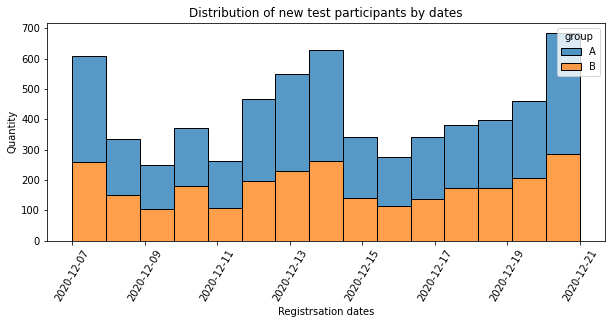

In [13]:
# building the distribution by registration dates
rst_participants.groupby('first_date').agg({'user_id': 'count'})

plt.figure(figsize=(10,4))
ax = sns.histplot(data=rst_participants, bins=15, x='first_date', hue='group', multiple='stack')
ax.set_title('Distribution of new test participants by dates')
ax.set_xlabel('Registrsation dates')
ax.set_ylabel('Quantity')
plt.xticks(rotation=60)
plt.show()

**CONCLUSIONS:**
* Test participants were registered from December 7 to December 21, as it is written in the TOR.
* In general, the ratio between groups A and B is close on each date.

### Checking the dates of events and the date the test was stopped

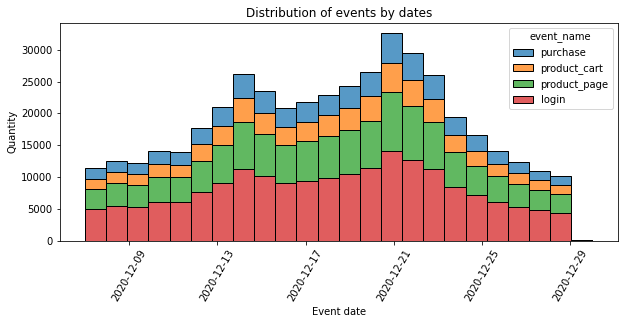

In [14]:
plt.figure(figsize=(10,4))
ax = sns.histplot(data=events, x='date', bins= 24, hue='event_name', multiple='stack')
ax.set_title('Distribution of events by dates')
ax.set_xlabel('Event date')
ax.set_ylabel('Quantity')
plt.xticks(rotation=60)
plt.show()

**CONCLUSIONS:**
* According to the TOR, there should be data until January 4, but we only have data until December 29. There are also very few events from December 30th. This means that users registered from December 17 to December 21 did not have time to live 14 days. We need to check how much this can affect the results of the study.

Let's check how many days it usually takes to make an event for the first time:
* filter out users who came from December 7 to December 16 (i.e. lived all 14 days),
* calculate for each how many days have passed from the moment of registration to the first event for each type of events,
* display aggregated data.

In [15]:
# collecting the data about the events of users who came from December 7 to December 16
users_events = (
    users.query('(first_date >= "2020-12-07") & (first_date <= "2020-12-16")')
    .merge(events[['user_id', 'event_name', 'date']], on='user_id', how='left')
)

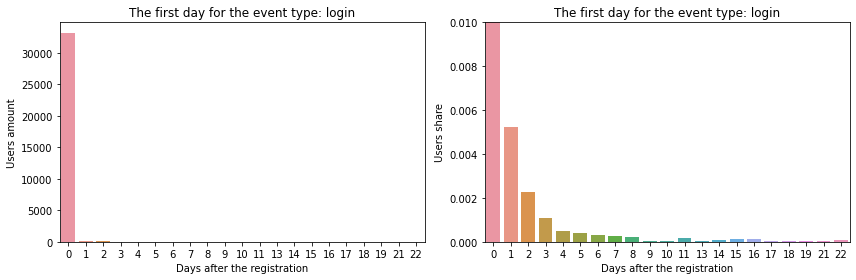

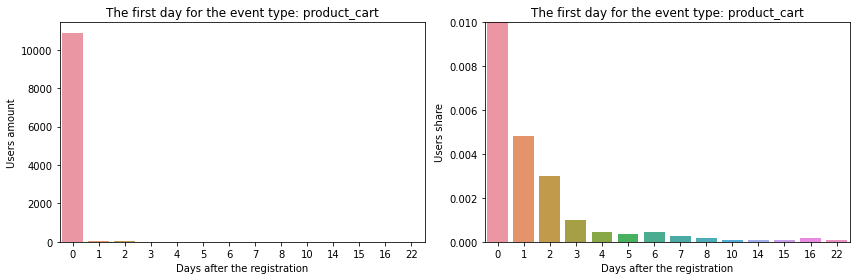

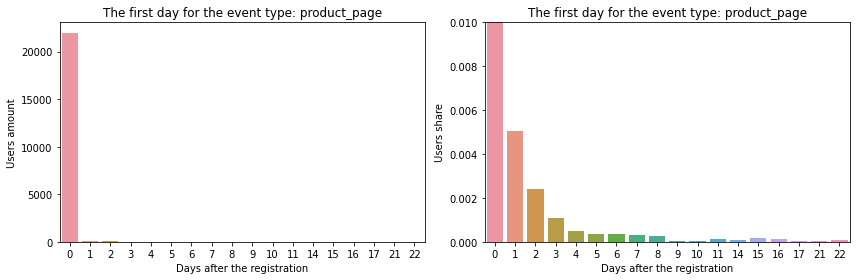

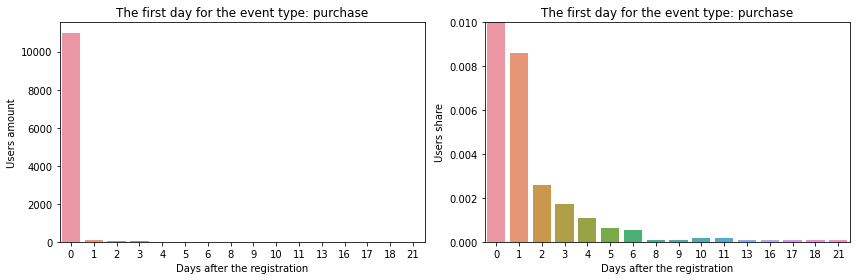

In [16]:
# collecting the information about first events
users_events = (
    users_events.groupby(by=['user_id', 'first_date', 'event_name'], as_index=False)
    .agg({'date': 'min'})
)

# adding the difference in days between the event day and the first day
users_events['days_after_reg'] = users_events['date'] - users_events['first_date']
users_events['days_after_reg'] = users_events['days_after_reg'].map(lambda x: x.days).astype('Int8')

# building graphs
for name in users_events['event_name'].unique():
    report = (
        users_events.query('event_name == @name')
        .groupby('days_after_reg', as_index=False)
        .agg({'user_id': 'nunique'})
    )
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    title = 'The first day for the event type: ' + name
    report['share'] = report['user_id'] / report['user_id'].sum()
    sns.barplot(data=report, x='days_after_reg', y='user_id', ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Users amount')
    ax1.set_xlabel('Days after the registration')
    sns.barplot(data=report, x='days_after_reg', y='share',ax=ax2)
    ax2.set_title(title)
    ax2.set_ylabel('Users share')
    ax2.set_xlabel('Days after the registration')
    ax2.set_ylim(0, 0.01)
    plt.tight_layout()
    plt.show()

**CONCLUSION:**
* Almost all events for the first time take place on the day of registration or, at the latest, 1-2 days after. Therefore, we can take data of users registered after December 16 - an incompleted period of 14 days will have almost no effect.

### Checking if there are intersections with other tests

In [17]:
# filtering those test participants who are in other tests, looking at these tests
(
    rst_participants[rst_participants['user_id'].isin(participants.query('ab_test != "recommender_system_test"')['user_id'])]
    .merge(participants.query('ab_test != "recommender_system_test"')[['user_id', 'ab_test', 'group']], on='user_id', how='left')
    .groupby('ab_test_y', as_index=False)
    .agg({'user_id': 'count'})
)

,ab_test_y,user_id
0,interface_eu_test,1602


There are intersections with the test named interface_eu_test, 1602 people. Let's check the distribution by groups

In [18]:
# checking the distribution by groups between overlapping participants of two tests
vs_interface = (
    rst_participants[rst_participants['user_id'].isin(participants.query('ab_test != "recommender_system_test"')['user_id'])]
    .merge(participants.query('ab_test != "recommender_system_test"')[['user_id', 'ab_test', 'group']], on='user_id', how='left')
    .pivot_table(index='group_x', columns='group_y', values='user_id', aggfunc='count')
)

# adding all participants
vs_interface['All'] = rst_participants.groupby('group').agg({'user_id': 'count'})

# calculationg shares
vs_interface['share_A'] = vs_interface['A'] / vs_interface['All']
vs_interface['share_B'] = vs_interface['B'] / vs_interface['All']
vs_interface

group_y,A,B,All,share_A,share_B
group_x,,,,,
A,482,439,3634,0.132636,0.120804
B,337,344,2717,0.124034,0.126610


**CONCLUSION:**
* The shares of groups A and B in interface_eu_test are distributed almost evenly among the groups of recommender_system_test. There is no reason to believe that the intersection with interface_eu_test will greatly affect the results of recommender_system_test.

### Checking whether there are any overlaps with marketing activities

In [19]:
# for verification, collecting a dataframe of events of test participants
rst_participants_events = rst_participants.merge(
    events.query('date < "2020-12-30"')[['user_id', 'event_name', 'date']], on='user_id', how='left'
)

rst_participants_events.info()
rst_participants_events.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26286 entries, 0 to 26285
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     26286 non-null  object        
 1   group       26286 non-null  object        
 2   ab_test     26286 non-null  object        
 3   first_date  26286 non-null  datetime64[ns]
 4   region      26286 non-null  object        
 5   device      26286 non-null  object        
 6   event_name  23416 non-null  object        
 7   date        23416 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(6)
memory usage: 1.8+ MB


,user_id,group,ab_test,first_date,region,device,event_name,date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,purchase,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,purchase,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,product_cart,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,product_cart,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,product_page,2020-12-07


In [20]:
# setting the start and the end date for checking
start_dt = rst_participants_events['date'].min()
end_dt = rst_participants_events['date'].max()

#
projects['start_before_end_during'] = (projects['start_dt'] < start_dt) &\
    (projects['finish_dt'] >= start_dt) & (projects['finish_dt'] <= end_dt)
projects['start_during_end_during'] = (start_dt <= projects['start_dt']) & (projects['start_dt'] <= end_dt) &\
    (projects['finish_dt'] >= start_dt) & (projects['finish_dt'] <= end_dt)
projects['start_during_end_after'] = (start_dt <= projects['start_dt']) & (projects['start_dt'] <= end_dt) &\
    (projects['finish_dt'] > end_dt)
projects['start_before_end_after'] = (projects['start_dt'] < start_dt) & (projects['finish_dt'] > end_dt)

projects['cross'] = projects['start_before_end_during'] | projects['start_during_end_during'] |\
    projects['start_during_end_after'] | projects['start_before_end_after']

projects.query('cross == True')


,name,regions,start_dt,finish_dt,start_before_end_during,start_during_end_during,start_during_end_after,start_before_end_after,cross
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,False,False,True,False,True


There is an intersection with the campaign Christmas&New Year Promo. To check how much the campaign could have affected, let's check the distribution of test groups on dates without intersection and with intersection by the number of events.

In [21]:
# calculating data before December 25
vs_christmas = (
    rst_participants_events.query('date < "2020-12-25"')
    .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count')
    .reset_index()
)

# adding status 'before'
vs_christmas['status'] = 'before'

# calculating the data after December 25
vs_christmas_after = (
    rst_participants_events.query('date >= "2020-12-25"')
    .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count')
    .reset_index()
)

# adding status 'after'
vs_christmas_after['status'] = 'after'

#  connecting dataframes
vs_christmas = pd.concat([vs_christmas, vs_christmas_after], axis=0)

# calculating the share
vs_christmas['share_B'] = vs_christmas['B'] / (vs_christmas['A'] + vs_christmas['B'])

vs_christmas

group,event_name,A,B,status,share_B
0,login,6960,2213,before,0.241251
1,product_cart,2087,604,before,0.224452
2,product_page,4460,1193,before,0.211038
3,purchase,2144,595,before,0.217233
0,login,1164,256,after,0.180282
1,product_cart,335,48,after,0.125326
2,product_page,767,133,after,0.147778
3,purchase,392,65,after,0.142232


**CONCLUSION:**
* The share of events of Group B participants during the Christmas&New Year Promo campaign is significantly lower than before the campaign. However, intersection with the campaign will have almost no effect on the test results, because enrollment in the test was stopped after December 21th, and almost all users take their first action of each type on the day of registration or the next day. Thus, events after December 25th have almost no effect on conversion.

### Removing events from the dataframe with events that refer to more than 14 days after registration

In [22]:
# making a column with the amount of days after registration
rst_participants_events['days_after_reg'] = rst_participants_events['date'] - rst_participants_events['first_date']
rst_participants_events['days_after_reg'] = rst_participants_events['days_after_reg'].map(lambda x: x.days).astype('Int8')

# filtering data
rst_participants_events = rst_participants_events.query('(days_after_reg.isna()) | (days_after_reg < 14)')

rst_participants_events.info()
rst_participants_events.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25490 entries, 0 to 26285
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         25490 non-null  object        
 1   group           25490 non-null  object        
 2   ab_test         25490 non-null  object        
 3   first_date      25490 non-null  datetime64[ns]
 4   region          25490 non-null  object        
 5   device          25490 non-null  object        
 6   event_name      22620 non-null  object        
 7   date            22620 non-null  datetime64[ns]
 8   days_after_reg  22620 non-null  Int8          
dtypes: Int8(1), datetime64[ns](2), object(6)
memory usage: 1.8+ MB


,user_id,group,ab_test,first_date,region,device,event_name,date,days_after_reg
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,purchase,2020-12-07,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,product_cart,2020-12-07,0
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,product_page,2020-12-07,0
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,login,2020-12-07,0
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,product_page,2020-12-20,0


**CONCLUSION:**
* We removed from the dataframe events that occurred more than 14 days after registration. According to the terms of reference, we must only analyze events that occurred within 14 days after registration.

**CONCLUSIONS FOR THE SECTION:**
* There are 6351 people in the test, while there are significantly more people in group A.
* Test participants were registered from December 7 to December 21, as it is written in the TOR.
* There is data on events only up to December 30. This means that users who registered after December 16 did not live 14 days. But this has almost no effect on the conversion, because the first action occurs on the day of registration or in 1-2 days after.
* There are users that overlap with another A/B test, but the group shares of both tests are fairly evenly distributed, so we shouldn't expect much overlap influence.
* There is an intersection with marketing activity after December 25, but this data is not key in terms of conversion.

## EDA

### Looking at the distribution of the number of events in samples

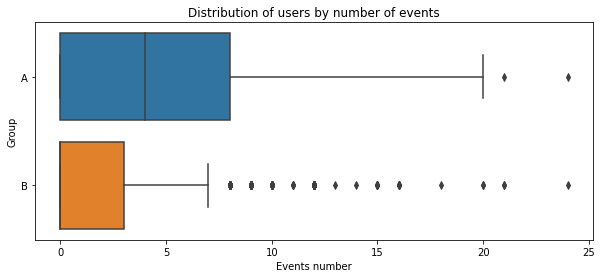

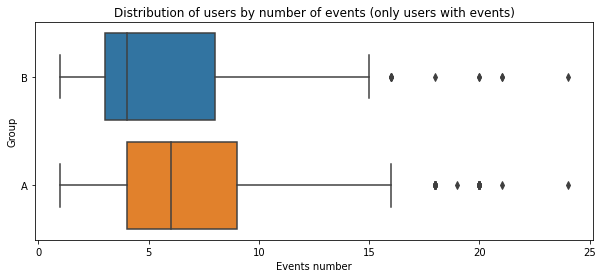

In [23]:
# Building the distribution based on the number of events per client
plt.figure(figsize=(10, 4))
ax = sns.boxplot(
    data=rst_participants_events.groupby(['user_id', 'group'], as_index=False).agg({'event_name': 'count'}),
    y='group', x='event_name'
)
ax.set_title('Distribution of users by number of events')
ax.set_xlabel('Events number')
ax.set_ylabel('Group')
plt.show()

# Building the distribution based on the number of events per client only for clients with events
plt.figure(figsize=(10, 4))
ax = sns.boxplot(
    data=rst_participants_events[~rst_participants_events['event_name'].isna()]
    .groupby(['user_id', 'group'], as_index=False).agg({'event_name': 'count'}),
    y='group', x='event_name'
)
ax.set_title('Distribution of users by number of events (only users with events)')
ax.set_xlabel('Events number')
ax.set_ylabel('Group')
plt.show()

**CONCLUSIONS:**
* More than half of the users in group B have zero events.
* Users in group A have significantly more events per person, even without users with no events.

### Calculating the average number of events

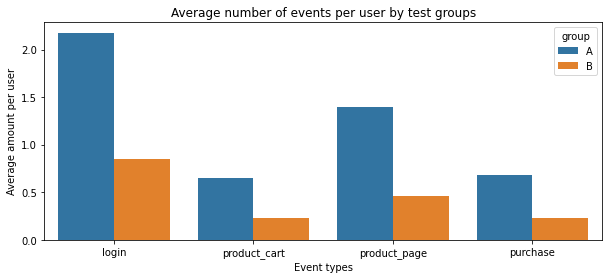

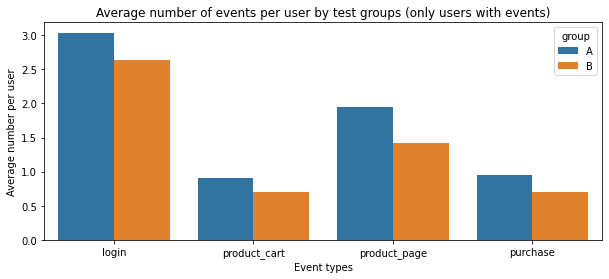

In [24]:
# counting the number of events by groups
av_events = (
    rst_participants_events.groupby(['group', 'event_name'], as_index=False)
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'events'})
)
av_events = av_events.merge(
    rst_participants_events.groupby('group', as_index=False)
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'users'})
    [['group', 'users']],
    on='group',
    how='left'
)

# calculateing the average number per user
av_events['event_per_user'] = av_events['events'] / av_events['users']

# building the graph
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=av_events, x='event_name', hue='group', y='event_per_user')
ax.set_title('Average number of events per user by test groups')
ax.set_xlabel('Event types')
ax.set_ylabel('Average amount per user')
plt.show()


# counting the number of events by groups, excluding users with zero events
av_events = (
    rst_participants_events.groupby(['group', 'event_name'], as_index=False)
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'events'})
)
av_events = av_events.merge(
    rst_participants_events[~rst_participants_events['event_name'].isna()]
    .groupby('group', as_index=False)
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'users'})
    [['group', 'users']],
    on='group',
    how='left'
)

# calculating the average events number per user
av_events['event_per_user'] = av_events['events'] / av_events['users']

# building the graph
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=av_events, x='event_name', hue='group', y='event_per_user')
ax.set_title('Average number of events per user by test groups (only users with events)')
ax.set_xlabel('Event types')
ax.set_ylabel('Average number per user')
plt.show()

**CONCLUSION:**
* Users in group A are much more likely to make events than users in group B. But this large difference is due to the large number of users with zero events in group B.
* If users with zero events are excluded, group A still has more events per user on average, but the difference between groups is small.

### Looking at how the number of events in the samples is distributed by days

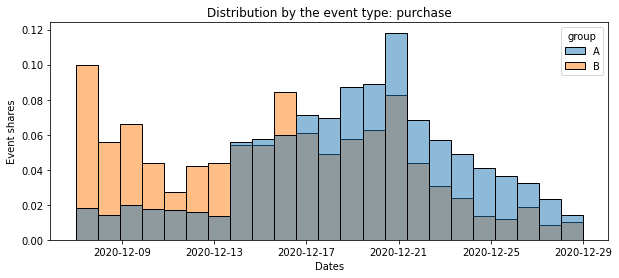

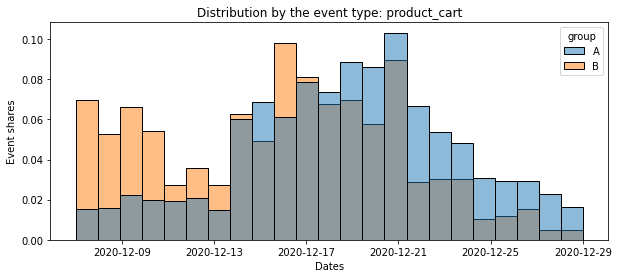

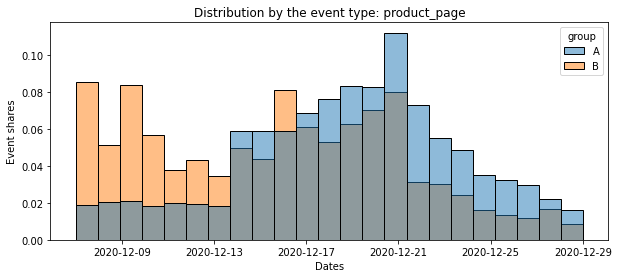

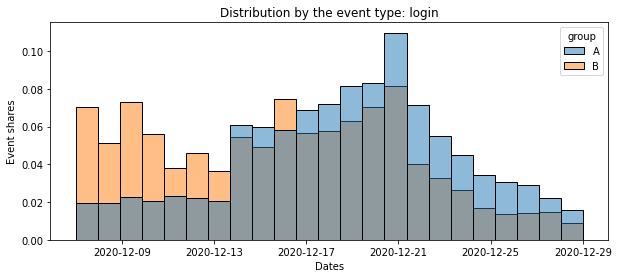

In [25]:
# building histograms separately for each type of event
for event in rst_participants_events[~rst_participants_events['event_name'].isna()]['event_name'].unique():
    plt.figure(figsize=(10, 4))
    ax = sns.histplot(
        data=rst_participants_events.query('event_name == @event'), x='date', bins=23, hue='group', stat='density', common_norm=False
    )
    title = 'Distribution by the event type: ' + str(event)
    ax.set_title(title)
    ax.set_ylabel('Event shares')
    ax.set_xlabel('Dates')
    plt.show()

Now looking at this regarding registration days

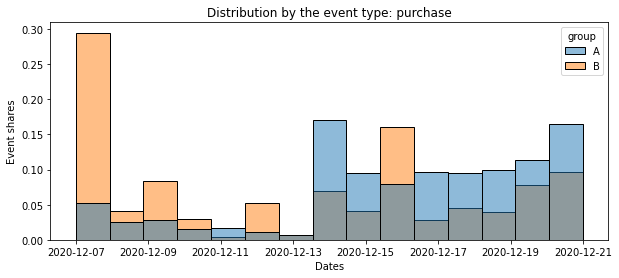

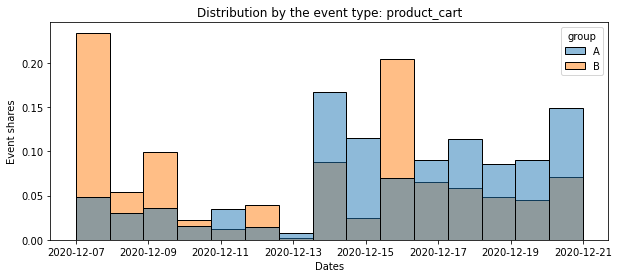

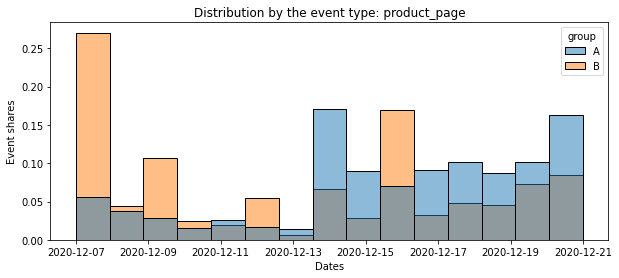

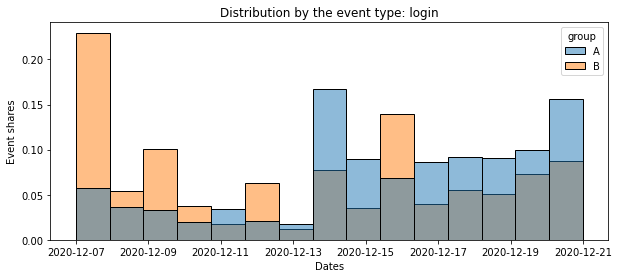

In [26]:
# building histograms separately for each type of event
for event in rst_participants_events[~rst_participants_events['event_name'].isna()]['event_name'].unique():
    plt.figure(figsize=(10, 4))
    ax = sns.histplot(
        data=rst_participants_events.query('event_name == @event'), x='first_date', bins=15, hue='group', stat='density', common_norm=False
    )
    title = 'Distribution by the event type: ' + event
    ax.set_title(title)
    ax.set_ylabel('Event shares')
    ax.set_xlabel('Dates')
    plt.show()

**CONCLUSIONS:**
* The number of events in group A was low in the first week of the test, but then increased sharply. In group B, the distribution by date was more even, so the first week of the test in group B has a significantly larger proportion of events than in group A.
* Group A has very few events for users registered in the first week of the test. After that, the number of events increased sharply. In group B, 25% of events, on the contrary, fall on users registered on the first day of the test.

### Analyzing users without events

In [27]:
# adding the column separating users who have event and who don't have events
rst_participants['no_events'] = (
    rst_participants['user_id'].map(
        lambda x: True if x in rst_participants_events.query('event_name.isna()')['user_id'].to_list() else False
    )
)

rst_participants.head()

,user_id,group,ab_test,first_date,region,device,no_events
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,False
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,False
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac,False
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone,False
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC,True


In [28]:
print('Number of users without events: {}'.format(len(rst_participants.query('no_events == True'))))
print()
print('Share of users without events: {0:.1f}%'.format(rst_participants['no_events'].mean() * 100))
print()
print('Distribution of users with no events by groups of the test')

# building the distribution of users with no events by groups of the test
(
    rst_participants.query('no_events == True')
    .groupby('group', as_index=False)
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'users_with_no_events'})
    .merge(
        rst_participants.groupby('group', as_index=False)
        .agg({'no_events': 'mean'})
        .rename(columns={'no_events': 'share_of_no_events_users'}),
        on='group', how='left'
    )
)
print()

Number of users without events: 2870

Share of users without events: 45.2%

Distribution of users with no events by groups of the test



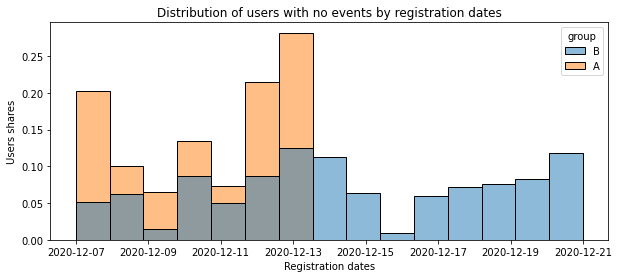

In [29]:
# building the graph
plt.figure(figsize=(10, 4))
ax = sns.histplot(
    data=rst_participants.query('no_events == True'), x='first_date', bins=15, hue='group', stat='density', common_norm=False
)
ax.set_title('Distribution of users with no events by registration dates')
ax.set_ylabel('Users shares')
ax.set_xlabel('Registration dates')
plt.show()

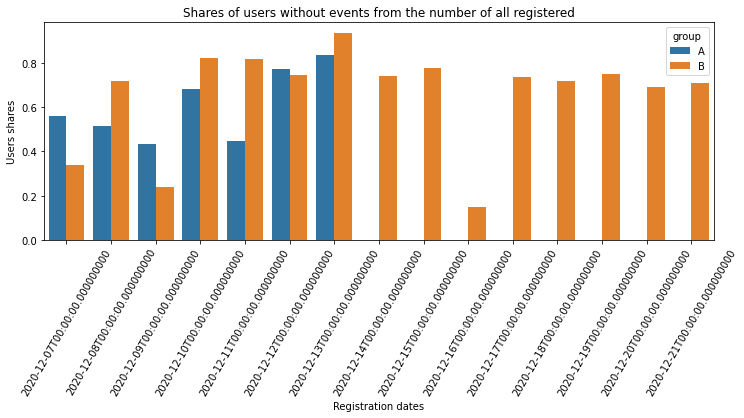

In [30]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=rst_participants.groupby(['group', 'first_date'], as_index=False).agg({'no_events': 'mean'}), 
    x='first_date', 
    y='no_events',
    hue='group'
)
ax.set_title('Shares of users without events from the number of all registered')
ax.set_ylabel('Users shares')
ax.set_xlabel('Registration dates')
plt.xticks(rotation=60)
plt.show()

**CONCLUSIONS:**
* In total, in group A, 28% of users did not make an event, in group B - 68%. The total value for both groups is 45%.
* In the first week of registration, the proportion of users without events was high in both groups. It was probably a technical error. Starting from the second week of the test, in group A the error was fixed, and users without events disappeared. But in group B, the error remained and led to a high proportion of users without events in the end.

### Building conversion funnels

In [31]:
# calculating data for the funnel
funnel = (
    rst_participants_events.groupby(['group', 'event_name'], as_index=False)
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'users'})
)

# writing the funnel A with the required sorting and calculating the conversion
funnel_A = pd.DataFrame()
for i in ['login', 'product_page', 'product_cart', 'purchase']:
    funnel_A = pd.concat([funnel_A, funnel.query('(event_name == @i) & (group == "A")')])
funnel_A['conversion'] = round(funnel_A['users'] / funnel_A['users'].max(), 3)
funnel_A['conversion_from_previous'] = round(funnel_A['users'] / funnel_A.shift(1)['users'], 3)

# writing the funnel B with the required sorting
funnel_B = pd.DataFrame()
for i in ['login', 'product_page', 'product_cart', 'purchase']:
    funnel_B = pd.concat([funnel_B, funnel.query('(event_name == @i) & (group == "B")')])
funnel_B['conversion'] = round(funnel_B['users'] / funnel_B['users'].max(), 3)
funnel_B['conversion_from_previous'] = round(funnel_B['users'] / funnel_B.shift(1)['users'], 3)

In [32]:
funnel_A

,group,event_name,users,conversion,conversion_from_previous
0,A,login,2604,1.000,NaN
2,A,product_page,1685,0.647,0.647
1,A,product_cart,782,0.300,0.464
3,A,purchase,833,0.320,1.065


In [33]:
funnel_B

,group,event_name,users,conversion,conversion_from_previous
4,B,login,876,1.000,NaN
6,B,product_page,493,0.563,0.563
5,B,product_cart,244,0.279,0.495
7,B,purchase,249,0.284,1.020


**CONCLUSIONS:**
* Group B has a lower conversion rate across all three funnel steps than Group A.
* Conversion to purchase in both groups is higher than on the shopping cart page. This suggests that there is a way to pay for the purchase not through the basket.

**CONCLUSIONS FOR THE SECTION:**
* In the first week of the test, there were very few users of group A, then there were sharply more of them.
* In group B, more than half of the participants did not perform a single action. Perhaps there were some technical problems that prevented users from logging into their account.
* In group A, the average number per person of all types of events is higher than in group B.
* In group A, the conversion for all event types is higher than in group B.

## Evaluation of A/B test results

### Writing the fuction for checking test results

In [34]:
def hypo_testing(data, event, base_event, alpha=0.05):

    # number of users, who made an event
    event_users_A = data.query('(event_name == @event) & (group == "A")')['users'].sum()
    event_users_B = data.query('(event_name == @event) & (group == "B")')['users'].sum()
    event_users = [event_users_A, event_users_B]

    # total number of users
    total_users_A = data.query('(event_name == @base_event) & (group == "A")')['users'].sum()
    total_users_B = data.query('(event_name == @base_event) & (group == "B")')['users'].sum()
    total_users= [total_users_A, total_users_B]

    # share of users who made an event
    p1 = event_users_A / total_users_A
    p2 = event_users_B / total_users_B

    # combined share
    p_combined = sum(event_users) / sum(total_users)

    # share difference
    difference = p2 - p1

    # calculating z_value
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / total_users_A + 1 / total_users_B))

    # setting the standard normal distribution
    distr = st.norm(0, 1)

    # calculating p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    if p_value < alpha:
        decision = "We reject the null hypothesis"
    else:
        decision = "We can't reject the null hypothesis"

    return difference, p_value, decision

### Testing the hypothesis of conversion equality

**Null hypothesis:** The conversions of all events in groups A and B are equal.

**Alternative Hypothesis:** There is a statistically significant difference between group A and group B conversions for at least one event.

The base significance level is 0.05. Our hypothesis consists of three types of events, and we test separately each of them. As the number of events increases, the probability of a Type I error (the probability of rejecting a true null hypothesis) increases, so we additionally use the Bonferroni correction to calculate the significance level.

In [35]:
# creating empty list for writing
results = []

# applying the function to all types of events (significance level according to the Bonferroni correction)
for event in ['product_page', 'product_cart', 'purchase']:
    difference, p_value, decision = hypo_testing(funnel, event, 'login', 0.05/3)
    string = [event, difference, p_value, decision]
    results.append(string)

# transforming to a dataframe
results = pd.DataFrame(results, columns=['event', 'difference', 'p_value', 'decision'])
results

,event,difference,p_value,decision
0,product_page,-0.084296,0.000008,We reject the null hypothesis
1,product_cart,-0.021768,0.221594,We can't reject the null hypothesis
2,purchase,-0.035646,0.048648,We can't reject the null hypothesis


**CONCLUSION:**
* We reject the null hypothesis. There are statistically significant differences between product page conversions between groups A and B. Group B's conversion rate is lower than group A's by 8.4%.

## Выводы

1. The conducted A / B test has limitations and deviations from the TOR:
     * There are significantly fewer participants in group B than in group A. At the same time, more than half of the participants in group B did not do any action. Perhaps there were some technical problems.
     * The dynamics of the total number of events on different dates in groups A and B varies greatly. Perhaps, again, there were technical problems, or incorrect distribution of people into groups.
     * The test overlaps with another test (1602 people out of 6351), while the distribution across groups is fairly even. However, the intersection of tests may affect the result.
     * 45% of test participants did not do any event. 67% of test participants in group B did not do any of the events. It was probably a technical error. This error was corrected for group A after the first week of the test, but was not corrected for group B.
     * There is data on events only up to December 30. This means that users who registered after December 16 did not live 14 days. But this has almost no effect on the conversion, because the first action occurs on the day of registration or in 1-2 days after.
     * There is an intersection with marketing activity after December 25, but this data is not key in terms of conversion.
2. The number of events in group A was low in the first week of the test, but then increased sharply. In group B, the distribution by date was more even, so the first week of the test in group B has a significantly larger proportion of events than in group A. Group A has very few events for users registered in the first week of the test. After that, the number of events increased sharply. In group B, 25% of events, on the contrary, fall on users registered on the first day of the test.
3. According to the results of the A/B test, it was found that there is a statistically significant difference between groups A and B in terms of conversion to the product page. At the same time, the conversion in group A is higher at each stage. This suggests that the new recommender system performed worse than the old one.
4. Test results may have been affected by deviation from the TOR. But the difference between groups is high, so it's not recommended to make another A/B test of this new recommender system.